In [ ]:
"""Strain estimation from Zach's electrostatic adheasion data"""
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('Data/Tensile Data/PVC Gel Material Parameters.csv')

# Zachs data was recorded at 1500V/mm E field with stress in mN/cm^2.
maxElectrostaticStress = [2000, 1750, 1250, 1500]

# convert from mN/cm^2. 1 mN/cm^2 = 10 pascals
maxElectrostaticStress = [i*10 for i in maxElectrostaticStress]
strain = []

# estimate the strain from the elastic modulus and max electrostatic stress
for i in range(0, len(maxElectrostaticStress)):
    strain.append(maxElectrostaticStress[i]/data["Elastic Modulus (Pa)"][i])

name = ['P2', 'P4', 'P6', 'P8']
for i in range(0, len(maxElectrostaticStress)):
    plt.scatter(strain[i], maxElectrostaticStress[i], label = f'{name[i]}')

plt.xlabel('Strain')
plt.ylabel('Adheasion Stress (Pa)')
plt.title('Maximum Strain in a Linear Actuator')
plt.legend()
plt.show()

# Zach's data looks at round cut PVC gels where the electrode takes up all the 
# area of the gel. in the EPIC, the electrode compresses the fluid towards the 
# center, where there's significantly more gel material. this means for the 
# given force, the pressure is significantly lowered as there is more area to 
# consider. this relationship is the absolulte maximum potential 

Elastic fitting

P2 Elastic Modulus (Pa): [291012.96496304    543.44544266], Poissons Ratio: [0.40327323 0.01116433],  752152.1073593217
P4 Elastic Modulus (Pa): [55648.91978047   118.21017533], Poissons Ratio: [0.41283669 0.00422646],  159611.0764194055
P6 Elastic Modulus (Pa): [24940.93338144  -145.56578248], Poissons Ratio: [0.37585813 0.00057433],  50226.676884077104
P8 Elastic Modulus (Pa): [11484.32574184  -279.58653113], Poissons Ratio: [0.34422233 0.0004673 ],  18430.634856004654


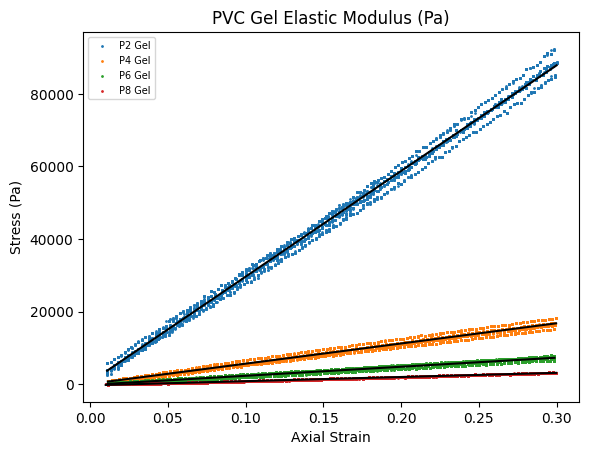

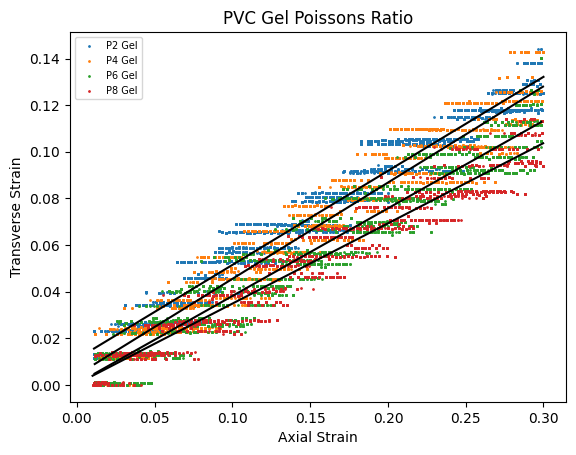

In [16]:
"""Elastic modulus and poissons ratio"""
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt; import numpy as np
from pvc_tensile_experiment.Functions import *

def LinearFit(x, a, b):
    return a*x + b

# create a dataframe to save the data 
df = pd.DataFrame(columns = ["Plasticizer", "Elastic Modulus (Pa)", "Poissons Ratio", "Bulk Modulus"])
i = 0

# the desired plasticizer ratio 
for plastiRatio in ['P2', 'P4', 'P6', 'P8']:

    # compile all the data  
    _, axStrain, _, transStrain, stress = DataCompile('Tensile Data/Elastic Data', plastiRatio)

    # define the elastic region
    elasRegion = [list(axStrain).index(i) for i in axStrain if i < 0.30 and i > 0.01]
    elasAxStrain = axStrain[elasRegion]
    elasTransStrain = transStrain[elasRegion]
    elasStress = stress[elasRegion]*1e6

    # curve fit the elastic region. 
    xfit = np.linspace(elasAxStrain[0], elasAxStrain[-1])
    poptE, pcovE = curve_fit(LinearFit, elasAxStrain, elasStress)
    poptP, pcovP = curve_fit(LinearFit, elasAxStrain, elasTransStrain)
    print(f'{plastiRatio} Elastic Modulus (Pa): {poptE}, Poissons Ratio: {poptP},  {poptE[0]/2/(1 - 2*poptP[0])}')

    # plot engineering stress vs strain
    plt.figure(0)
    plt.scatter(elasAxStrain, elasStress, s = 1, label = f'{plastiRatio} Gel')
    plt.plot(xfit, LinearFit(xfit, poptE[0], poptE[1]), 'black')
    plt.xlabel('Axial Strain')
    plt.ylabel('Stress (Pa)')
    plt.title(f'PVC Gel Elastic Modulus (Pa)')
    plt.legend(fontsize = 7)

    # plot poissons ratio
    plt.figure(1)
    plt.scatter(elasAxStrain, elasTransStrain, s = 1, label = f'{plastiRatio} Gel')
    plt.plot(xfit, LinearFit(xfit, poptP[0], poptP[1]), 'black', )
    plt.xlabel('Axial Strain')
    plt.ylabel('Transverse Strain')
    plt.title(f'PVC Gel Poissons Ratio')
    plt.legend(fontsize = 7)

    df.loc[i] = [plastiRatio, poptE[0], poptP[0], poptE[0]/2/(1 - 2*poptP[0])]
    i = i + 1
plt.show()

df.to_csv(f"Data/PVC Gel Material Parameters.csv", sep = ',', header = True, index = False)

Hyperealastic fitting

In [ ]:
"""Nominal Engineering-Stretch Hyperelastic Model Fitting"""
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
from pvc_tensile_experiment.Functions import *


# define the plasticizer ration we want
plastiRatio = 'P2'

# compile all the data  
_, axStrain, _, _, stress = TensileDataCompile(plastiRatio)

# convert from engineering measurements to true measurements
stretch = 1 + axStrain
stress = stress*1e6

# Define hyperelastic models
def NeoHookean(params, stretch):
    mu = params[0]
    return mu*(stretch - 1/stretch**2)

def MooneyRivlin(params, stretch):
    C10, C01 = params
    return 2*(stretch - 1/stretch**2)*(C10 + C01/stretch)

def Yeoh(params, stretch):
    C10, C20, C30 = params
    I1 = stretch**2 + 2/stretch
    return 2*(stretch - 1/stretch**2)*(C10 + 2*C20*(I1 - 3) + 3*C30*(I1 - 3)**2)

def InvLangevin(x):
    if np.abs(x) < 0.84136:
        return 1.31446*np.tan(1.58986*x) + 0.91209*x
    elif np.abs(x) >= 0.84136:
        return 1/(np.abs(x)/x*-x)

def EightChain(params, stretch):
    mu, stretchLock = params
    chainStretch = np.sqrt((stretch**2 + 2/stretch)/3)    
    return mu/chainStretch*(stretch**2 - 1/stretch)*InvLangevin(chainStretch/stretchLock)/InvLangevin(1/stretchLock)

def Ogden(params, stretch):
    mu, alpha, mu1, alpha1, mu2, alpha2 = params
    return 2*mu/alpha*(stretch**(alpha - 1) - stretch**(-alpha/2 - 1)) + 2*mu1/alpha1*(stretch**(alpha1 - 1) - stretch**(-alpha1/2 - 1)) + 2*mu2/alpha2*(stretch**(alpha2 - 1) - stretch**(-alpha2/2 - 1))

def Gent(params, stretch):
    mu, Jm = params
    return mu*(stretch - 1/stretch**2)*(Jm/(Jm - (stretch**2 + 2/stretch - 3)))

def ExtendedTube(params, stretch):
    Gc, Ge, beta, delta = params
    I1 = stretch**2 + 2/stretch
    return Gc*(stretch - 1/stretch**2)*((1 + (1 + I1**2 - 4*I1)*delta**2 + (5*I1 - I1**2 - 6)*delta**4)/(1 - (I1 - 3)*delta**2)**2) - 2*Ge/beta*(stretch**(-beta) - stretch**(beta/2))


# Define fitting function
def FitModel(model, stretch, stress, paramGuess):
    def residuals(params):
        return model(params, stretch) - stress
    optParams, _ = opt.least_squares(residuals, paramGuess, method = 'lm', max_nfev = 1000).x, None
    return optParams

# Compute R-squared
def RSquared(yTrue, yPredict):
    ssResidual = np.sum((yTrue - yPredict) ** 2)
    ssTotal = np.sum((yTrue - np.mean(yTrue)) ** 2)
    return 1 - (ssResidual / ssTotal)


# Models and initial guesses
models = {
    "Neo-Hookean": (NeoHookean, [1.0e6]),
    "Mooney-Rivlin": (MooneyRivlin, [1.0e6, 0.1e6]),
    "Yeoh": (Yeoh, [1.0e6, -0.1e4, 0.01e2]),
    "Gent": (Gent, [1.0e1, 100e6]),
    # "Arruda-Boyce": (EightChain, [1.0, 10]),
    "Ogden": (Ogden, [10.0e4, 1.0, -7.0e4, 2.0,  5.0e4, 2.0]),
    "ExtendedTube": (ExtendedTube, [1.0e6, 1.0e6, 0.7, 0.1])
}

# Fit models
fitResults = {}
for name, (model, guess) in models.items():
    params = FitModel(model, stretch, stress, guess)
    predictedStress = model(params, stretch)
    r2 = RSquared(stress, predictedStress)
    fitResults[name] = (params, r2)

# Print results
for name, (params, r2) in fitResults.items():
    print(f"{name} Model: Parameters = {params}, R^2 = {r2:.4f}")

# Plot results
plt.figure(figsize = (8, 6))
plt.scatter(stretch, stress, s = 2, label = "Data", color = "black")

for name, (params, _) in fitResults.items():
    plt.plot(stretch, models[name][0](params, stretch), label = name, linewidth = 2, linestyle = 'dotted')

plt.xlabel("Stretch Ratio")
plt.ylabel("Nominal Stress (MPa)")
plt.legend()
plt.title("Hyperelastic Model Fits")
plt.show()


In [ ]:
"""True Stress- Strain Hyperelastic Model Fitting"""
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
from pvc_tensile_experiment.Functions import *


# define the plasticizer ration we want
plastiRatio = 'P4'

# compile all the data  
axDist, axStrain, transDist, transStrain, stress = TensileDataCompile(plastiRatio)

# convert to true stress-strain
stretch = 1 + axStrain
trueStress = stress*stretch*1e6


# define hyperelastic models
def NeoHookean(params, stretch):
    mu = params[0]
    return mu*(stretch**2 - 1/stretch)

def MooneyRivlin(params, stretch):
    C10, C01 = params
    return 2*(stretch**2 - 1/stretch)*(C10 + C01/stretch)

def Yeoh(params, stretch):
    C10, C20, C30 = params
    I1 = stretch**2 + 2/stretch
    return 2*(stretch**2 - 1/stretch)*(C10 + 2*C20*(I1 - 3) + 3*C30*(I1 - 3)**2)

def InvLangevin(x):
    if np.abs(x) < 0.84136:
        return 1.31446*np.tan(1.58986*x) + 0.91209*x
    elif np.abs(x) >= 0.84136:
        return 1/(np.abs(x)/x*-x)

def EightChain(params, stretch):
    mu, stretchLock = params
    chainStretch = np.sqrt((stretch**2 + 2/stretch)/3)    
    return mu/chainStretch*(stretch**2 - 1/stretch)*InvLangevin(chainStretch/stretchLock)/InvLangevin(1/stretchLock)

def Ogden(params, stretch):
    mu, alpha, mu1, alpha1, mu2, alpha2 = params
    return 2*mu/alpha*(stretch**(alpha) - stretch**(-alpha/2)) + 2*mu1/alpha1*(stretch**(alpha1) - stretch**(-alpha1/2)) + 2*mu2/alpha2*(stretch**(alpha2) - stretch**(-alpha2/2))

def Gent(params, stretch):
    mu, Jm = params
    return mu*(stretch**2 - 1/stretch)*(Jm/(Jm - (stretch**2 + 2/stretch - 3)))

def ExtendedTube(params, stretch):
    Gc, Ge, beta, delta = params
    I1 = stretch**2 + 2/stretch
    return Gc*(stretch**2 - 1/stretch)*((1 + (1 + I1**2 - 4*I1)*delta**2 + (5*I1 - I1**2 - 6)*delta**4)/(1 - (I1 - 3)*delta**2)**2) - 2*Ge/beta*(stretch**(-beta) - stretch**(beta/2))


# define fitting function
def FitModel(model, stretch, trueStress, paramGuess):
    def residuals(params):
        return model(params, stretch) - trueStress
    optParams, _ = opt.least_squares(residuals, paramGuess, method = 'lm', max_nfev = 1000).x, None
    return optParams

# compute R-squared
def RSquared(yTrue, yPredict):
    ssResidual = np.sum((yTrue - yPredict) ** 2)
    ssTotal = np.sum((yTrue - np.mean(yTrue)) ** 2)
    return 1 - (ssResidual / ssTotal)


# models and initial guesses
models = {
    # "Neo-Hookean": (NeoHookean, [1.0]),
    # "Mooney-Rivlin": (MooneyRivlin, [1.0, 0.1]),
    "Yeoh": (Yeoh, [10.0e6, 10e4, 0.01e2]),
    # "Gent": (Gent, [1000, 100]),
    # "Arruda-Boyce": (EightChain, [1.0, 10]),
    "Ogden": (Ogden, [-0.27500592e6,  1.53251067,  0.49723726e6,  2.43781332, -0.22544583e6,  2.7956833 ]),
    "ExtendedTube": (ExtendedTube, [10.0e6, 5e6, 0.6, 0.02])
}

# Fit models
fitResults = {}
for name, (model, guess) in models.items():
    params = FitModel(model, stretch, trueStress, guess)
    predictedStress = model(params, stretch)
    r2 = RSquared(trueStress, predictedStress)
    fitResults[name] = (params, r2)

# Print results
for name, (params, r2) in fitResults.items():
    print(f"{name} Model: Parameters = {params}, R^2 = {r2:.4f}")

# Plot results
plt.figure(figsize = (8, 6))
plt.scatter(stretch, trueStress, s = 2, label = "Data", color = "black")

for name, (params, _) in fitResults.items():
    plt.plot(stretch, models[name][0](params, stretch), label = name)

plt.xlabel("True Strain")
plt.ylabel("True Stress")
plt.legend()
plt.title("Hyperelastic Model Fits")
plt.show()

Viscoelastic Processing

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# this function converts the raw excel file from the DMA to base units and converts into engineering stress-strain
def ViscoelasticDataProcessor(name):
    # import the excel file. dont use columns beyond 4 since they're empty
    # due to needing a place to put extra comments
    df = pd.read_excel(f"{name}", header = None, usecols = [0, 1, 2, 3, 4])
    name = name.removesuffix('.xlsx')

    # get sample geometric data. length is in mm and area is in mm^2
    sampleLength = df.loc[5][1]*1e-3
    sampleArea = df.loc[6][1]*1e-6

    # preallocate the measurement names
    columnNames = ['Time (s)', 'Temp. (Cel)', 'Displacement (m)', 'Load (N)', 'Displacement Rate (m/s)']

    # take the rows after the data headers 
    data = pd.DataFrame(df.loc[df.index[28::]].to_numpy(), columns = columnNames)

    # convert the data to base units. force and displacement were measured as micro-units. time is in minutes
    data['Time (s)'] = data['Time (s)']*60
    data['Load (N)'] = data['Load (N)']*1e-6
    data['Displacement (m)'] = data['Displacement (m)']*1e-6
    data['Displacement Rate (m/s)'] = data['Displacement Rate (m/s)']*1e-6*60

    # convert data to stress and strain. the units are already normalized
    data['Strain'] = data['Displacement (m)']/sampleLength
    data['Strain Rate (1/s)'] = data['Displacement Rate (m/s)']/sampleLength
    data['Stress (Pa)'] = data['Load (N)']/sampleArea

    # # plot stress and strain along time on a single axis
    # fig, ax = plt.subplots()
    # ax1 = ax.twinx()
    # ax.scatter(data['Time (min)'], data['Strain'], s = 1, c = 'r', label = 'Strain')
    # ax.set_ylabel('Strain (m/m)')
    # ax.set_xlabel('Time (min)')
    # ax.tick_params('y', colors = 'r')
    # ax.legend()
    # ax1.scatter(data['Time (min)'], data['Stress (Pa)'], s = 1, c = 'b',  label = 'Stress (Pa)')
    # ax1.set_ylabel('Stress (Pa)')
    # ax1.tick_params('y', colors = 'b')
    # ax1.legend()
    # plt.title(f'{name} Stress Relaxation')
    # plt.show()

    # save the processed data file for reference
    data.to_csv(f'{name} Processed.csv', sep = ',', header = True, index = False )
    return data


def StrainRateRegionSelector(strain):
    # find the indices wher strain has a large change
    regionIndices = np.where(np.diff(strain) > 1e-3)[0]

    # find where the index changes more than 1. this is used to segment each region
    startIndices = regionIndices[np.where(np.diff(regionIndices) > 1)[0] + 1]
    startIndices = np.insert(startIndices, 0, regionIndices[0])
    endIndices  = regionIndices[np.where(np.diff(regionIndices) > 1)[0]]
    endIndices = np.insert(endIndices, 2, regionIndices[-1])

    # define a np array to store the values. make the rows as long as the 30% strain region
    # since itll have the most data. 3 columns for each strain amplitude
    regions = np.zeros([endIndices[-1] - startIndices[-1], 3], dtype = int)

    # populate the region indices
    for i in range(0,3):
        indexRange = range(startIndices[i], endIndices[i])
        regions[range(0, len(indexRange)) ,i] = indexRange
    
    return regions

name = 'Book1.xlsx'
data  = ViscoelasticDataProcessor(f'{name}') # Data/Viscoelastic Data/Stress Relaxation Data/

expTime = data['Time (s)'].to_numpy(dtype = float)
strain = data['Strain'].to_numpy(dtype = float)
stress = data['Stress (Pa)'].to_numpy(dtype = int)
strainRate = np.average(data['Strain Rate (1/s)'].to_numpy(dtype = float))

regions = StrainRateRegionSelector(strain)

for i in range(0,3):
    indexRange = regions[regions[:,i] > 0, i]
    plt.scatter(expTime[indexRange], stress[indexRange], s = 1)
    plt.ylabel('Stress (Pa)')
    plt.xlabel('Time (s)')
    plt.title(f'{name} Stress Relaxation')
    plt.legend()
plt.show()

Viscoelastic Monotonic Strain Rate Fitting

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt


# define the Prony series and SLS model
def SLS(params, strain):
    EInf, E1, tau = params
    return EInf*strain + E1*tau*strainRate*(1 - np.exp(-strain/(tau*strainRate))) 

def Prony2Term(params, strain):
    EInf, E1, tau1, E2, tau2 = params

    return (EInf*strain +
            E1*tau1*strainRate*(1 - np.exp(-strain/(tau1*strainRate))) +
            E2*tau2*strainRate*(1 - np.exp(-strain/(tau2*strainRate))))

def Prony3Term(params, strain):
    EInf, E1, tau1, E2, tau2, E3, tau3 = params
    return (EInf*strain +
            E1*tau1*strainRate*(1 - np.exp(-strain/(tau1*strainRate))) +
            E2*tau2*strainRate*(1 - np.exp(-strain/(tau2*strainRate))) +
            E3*tau3*strainRate*(1 - np.exp(-strain/(tau3*strainRate))))


# define fitting function
def FitModel(model, strain, stress, paramGuess, boundaries):
    def residuals(params):
        return model(params, strain) - stress
    optParams, _ = opt.least_squares(residuals, paramGuess, bounds = boundaries, method = 'trf', max_nfev = 1000).x, None
    return optParams

# compute R-squared 
def RSquared(yTrue, yPredict):
    ssResidual = np.sum((yTrue - yPredict) ** 2)
    ssTotal = np.sum((yTrue - np.mean(yTrue)) ** 2)
    return 1 - (ssResidual / ssTotal)


# models and initial guesses
models = {
    "SLS": (SLS, [4e5, 12e4, 0.5], ([1e5, 1e5, 0.01], [1e6, 1e6, 1])),
    "Prony2Term": (Prony2Term, [296732, 100e3, 1, 100e3, 50],([1e5, 1e2 , 0.01, 1e3, 10], [3e6, 1e6, 1, 1e5, 100])),
    # "Prony3Term": (Prony3Term, [296732, 500e3, 0.1, 10e3, 5, 5e3, 50])
    }

for i in range(0,3):

    indexRange = regions[regions[:,i] > 0, i]
    strainfit = strain[indexRange]
    stressfit = stress[indexRange] - stress[indexRange[0]]

    # Fit models
    fitResults = {}
    for name, (model, guess, boundaries) in models.items():
        params = FitModel(model, strainfit, stressfit, guess, boundaries)
        predictedStress = model(params, strainfit)
        r2 = RSquared(stressfit, predictedStress)
        fitResults[name] = (params, r2)
        
    # Print results
    for name, (params, r2) in fitResults.items():
        print(f"{name} Model: Parameters = {params}, R^2 = {r2:.4f}")

    # Plot results
    plt.figure(figsize = (8, 6))
    plt.scatter(strainfit, stressfit, s = 2, label = "Data", color = "black")

    for name, (params, _) in fitResults.items():
        plt.plot(strainfit, models[name][0](params, strainfit), label = name)
        plt.legend()

In [ ]:
def SLS(params, t):
    EInf, E1, tau = params
    return E1 + EInf*np.exp(-t/tau)

def Prony2Term(params, t):
    EInf, E1, tau1, E2, tau2 = params
    return EInf + E1*np.exp(-t/tau1) + E2*np.exp(-t/tau2)


for i in np.linspace(0, 20, 410):
    plt.scatter(i, SLS(fitResults['SLS'][0], i), c = 'r', label = 'SLS')
    plt.scatter(i, Prony2Term(fitResults['Prony2Term'][0], i), c = 'b', label = 'Prony 2 Term')

Viscoelastic Stress Relaxation Curve Fitting

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt

# define the Prony series and SLS model
def SLS(params, t):
    EInf, E1, tau = params
    return E1 + EInf*np.exp(-t/tau)

def Prony2Term(params, t):
    EInf, E1, tau1, E2, tau2 = params
    return EInf + E1*np.exp(-t/tau1) + E2*np.exp(-t/tau2)

def Prony3Term(params, t):
    EInf, E1, tau1, E2, tau2, E3, tau3 = params
    return EInf + E1*np.exp(-t/tau1) + E2*np.exp(-t/tau2) + E3*np.exp(-t/tau3)


# define fitting function
def FitModel(model, t, stress, paramGuess):
    def residuals(params):
        return model(params, t) - stress
    optParams, _ = opt.least_squares(residuals, paramGuess, method = 'lm', max_nfev = 1000).x, None
    return optParams

# compute R-squared 
def RSquared(yTrue, yPredict):
    ssResidual = np.sum((yTrue - yPredict) ** 2)
    ssTotal = np.sum((yTrue - np.mean(yTrue)) ** 2)
    return 1 - (ssResidual / ssTotal)


# models and initial guesses
models = {
    "SLS": (SLS, [40e5, 200e3, 100]),
    "Prony2Term": (Prony2Term, [296732, 100e3, 1, 100e3, 50]),
    # "Prony3Term": (Prony3Term, [296732, 500e3, 0.1, 10e3, 5, 5e3, 50]),
    }

# Fit models
fitResults = {}
for name, (model, guess) in models.items():
    params = FitModel(model, Time, Stress, guess)
    predictedStress = model(params, Time)
    r2 = RSquared(Stress, predictedStress)
    fitResults[name] = (params, r2)
    
# Print results
for name, (params, r2) in fitResults.items():
    print(f"{name} Model: Parameters = {params}, R^2 = {r2:.4f}")

# Plot results
plt.figure(figsize = (8, 6))
plt.scatter(Time, Stress, s = 2, label = "Data", color = "black")

for name, (params, _) in fitResults.items():
    plt.plot(Time, models[name][0](params, Time), label = name)
    plt.legend()

Cross-link density measurements

In [ ]:
"""Cross link fitment"""
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt

# Constants for PVC Polymer
R = 8.314  # Universal gas constant (J/mol·K)
T = 0  # Room temperature (K)
nu = 5e-6  # Cross-link density (mol/cm³)
Mc = 30000  # Molecular weight between cross-links (g/mol)

# Engineering stress-strain data (Replace with real experimental data)
engineering_strain = axStrain
engineering_stress = stress

# Convert engineering to true stress and strain
trueStrain = np.log(1 + engineering_strain)
trueStress = engineering_stress * (1 + engineering_strain)

# Define the modified Yeoh model function
def modified_yeoh(I1, C1, C2, C3):
    additional_term = (nu * R * T / Mc) * (I1 - 3)  # Cross-link effect
    return C1 * (I1 - 3) + C2 * (I1 - 3)**2 + C3 * (I1 - 3)**3 + additional_term

# Function to fit true stress-strain data using Yeoh model
def fit_yeoh(trueStrain, trueStress):
    I1 = 2 * (trueStrain + 1)  # First invariant approximation for uniaxial tension
    
    def objective(params):
        C1, C2, C3 = params
        return modified_yeoh(I1, C1, C2, C3) - trueStress
    
    initial_guess = [0.20409796, -0.00736779,  0.00022124]  # Initial parameter estimates
    params_opt, _ = opt.least_squares(objective, initial_guess).x, None
    
    # Compute R-squared value
    fitted_stress = modified_yeoh(I1, *params_opt)
    ssResidual = np.sum((trueStress - fitted_stress) ** 2)
    ssTotal = np.sum((trueStress - np.mean(trueStress)) ** 2)
    r_squared = 1 - (ssResidual / ssTotal)
    
    return params_opt, r_squared, fitted_stress

# Fit the model
params_opt, r_squared, fitted_stress = fit_yeoh(trueStrain, trueStress)

# Plot results
plt.figure(figsize=(8, 5))
plt.scatter(trueStrain, trueStress, label='True Stress Data', color='blue')
plt.plot(trueStrain, fitted_stress, label=f'Modified Yeoh Fit (R²={r_squared:.4f})', color='red')
plt.xlabel('True Strain')
plt.ylabel('True Stress (MPa)')
plt.legend()
plt.title('Curve Fitting with Modified Yeoh Model for Over-Plasticized PVC')
plt.show()

# Print optimized parameters
print(f"Optimized C1: {params_opt[0]:.4f}, C2: {params_opt[1]:.4f}, C3: {params_opt[2]:.4f}")
print(f"R-squared: {r_squared:.4f}")
